# Student Accommodation With Preference Analysis and Geo-location Data

In [1]:
%load_ext lab_black
import pandas as pd
from pandas import json_normalize

pd.set_option("max_columns", None)

import numpy as np
import requests

from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import folium
from sklearn import preprocessing, cluster
import scipy

In [3]:
df = pd.read_csv("Data/food_coded.csv")
df

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food,comfort_food_reasons,comfort_food_reasons_coded,cook,comfort_food_reasons_coded.1,cuisine,diet_current,diet_current_coded,drink,eating_changes,eating_changes_coded,eating_changes_coded1,eating_out,employment,ethnic_food,exercise,father_education,father_profession,fav_cuisine,fav_cuisine_coded,fav_food,food_childhood,fries,fruit_day,grade_level,greek_food,healthy_feeling,healthy_meal,ideal_diet,ideal_diet_coded,income,indian_food,italian_food,life_rewarding,marital_status,meals_dinner_friend,mother_education,mother_profession,nutritional_check,on_off_campus,parents_cook,pay_meal_out,persian_food,self_perception_weight,soup,sports,thai_food,tortilla_calories,turkey_calories,type_sports,veggies_day,vitamins,waffle_calories,weight
0,2.4,2,1,430,NaN,315.0,1,none,we dont have comfort,9.0,2.0,9,NaN,eat good and exercise,1,1.0,eat faster,1,1,3,3.0,1,1.0,5.0,profesor,Arabic cuisine,3,1.0,rice and chicken,2,5,2,5,2,looks not oily,being healthy,8,5.0,5,5,1.0,1.0,"rice, chicken, soup",1.0,unemployed,5,1.0,1,2,5.0,3.0,1.0,1.0,1,1165.0,345,car racing,5,1,1315,187
1,3.654,1,1,610,3.0,420.0,2,"chocolate, chips, ice cream","Stress, bored, anger",1.0,3.0,1,1.0,I eat about three times a day with some snacks...,2,2.0,I eat out more than usual.,1,2,2,2.0,4,1.0,2.0,Self employed,Italian,1,1.0,"chicken and biscuits, beef soup, baked beans",1,4,4,4,5,"Grains, Veggies, (more of grains and veggies),...",Try to eat 5-6 small meals a day. While trying...,3,4.0,4,4,1.0,2.0,"Pasta, steak, chicken",4.0,Nurse RN,4,1.0,1,4,4.0,3.0,1.0,1.0,2,725.0,690,Basketball,4,2,900,155
2,3.3,1,1,720,4.0,420.0,2,"frozen yogurt, pizza, fast food","stress, sadness",1.0,1.0,1,3.0,"toast and fruit for breakfast, salad for lunch...",3,1.0,sometimes choosing to eat fast food instead of...,1,3,2,3.0,5,2.0,2.0,owns business,italian,1,3.0,"mac and cheese, pizza, tacos",1,5,3,5,6,usually includes natural ingredients; nonproce...,i would say my ideal diet is my current diet,6,6.0,5,5,7.0,2.0,"chicken and rice with veggies, pasta, some kin...",2.0,owns business,4,2.0,1,3,5.0,6.0,1.0,2.0,5,1165.0,500,none,5,1,900,I'm not answering this.
3,3.2,1,1,430,3.0,420.0,2,"Pizza, Mac and cheese, ice cream",Boredom,2.0,2.0,2,2.0,"College diet, cheap and easy foods most nights...",2,2.0,Accepting cheap and premade/store bought foods,1,3,2,3.0,5,3.0,2.0,Mechanic,Turkish,3,1.0,"Beef stroganoff, tacos, pizza",2,4,4,5,7,"Fresh fruits& vegetables, organic meats","Healthy, fresh veggies/fruits & organic foods",2,6.0,5,5,2.0,2.0,Grilled chicken \rStuffed Shells\rHomemade Chili,4.0,Special Education Teacher,2,1.0,1,2,5.0,5.0,1.0,2.0,5,725.0,690,NaN,3,1,1315,"Not sure, 240"
4,3.5,1,1,720,2.0,420.0,2,"Ice cream, chocolate, chips","Stress, boredom, cravings",1.0,1.0,1,2.0,I try to eat healthy but often struggle becaus...,2,2.0,I have eaten generally the same foods but I do...,3,4,2,2.0,4,1.0,4.0,IT,Italian,1,3.0,"Pasta, chicken tender, pizza",1,4,4,4,6,"A lean protein such as grilled chicken, green ...",Ideally I would like to be able to eat healthi...,2,6.0,2,5,1.0,1.0,"Chicken Parmesan, Pulled Pork, Spaghetti and m...",5.0,Substance Abuse Conselor,3,1.0,1,4,2.0,4.0,1.0,1.0,4,940.0,500,Softball,4,2,760,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,3.5,1,1,610,4.0,420.0,2,"wine. mac and cheese, pizza, ice cream",boredom and sadness,NaN,3.0,2,1.0,"My diet consists mainly of coffee, water, frui...",2,2.0,I have noticed there is less time for a prepar...,1,3,2,1.0,4,2.0,4.0,Accountant,Italian,1,1.0,Stromboli Mac and Cheese and Pizza,1,5,4,5,5,mainly protein and vegetables with a complex c...,My ideal diet would consist of a majority of w...,6,4.0,3,5,7.0,1.0,"pasta, fish, steak",3.0,Radiological Technician,5,3.0,1,4,3.0

In [4]:
df_clean = df.loc[
    :,
    [
        "cook",
        "eating_out",
        "employment",
        "ethnic_food",
        "exercise",
        "fruit_day",
        "income",
        "on_off_campus",
        "pay_meal_out",
        "sports",
        "veggies_day",
        "diet_current_coded",
        "fav_cuisine_coded",
        "pay_meal_out",
        "fav_food",
    ],
]
df_clean.dropna(axis=0, inplace=True)
df_clean.to_csv("Data/food_choices.csv")
df_clean.head()

,cook,eating_out,employment,ethnic_food,exercise,fruit_day,income,on_off_campus,pay_meal_out,sports,veggies_day,diet_current_coded,fav_cuisine_coded,pay_meal_out,fav_food
0,2.0,3,3.0,1,1.0,5,5.0,1.0,2,1.0,5,1,3,2,1.0
1,3.0,2,2.0,4,1.0,4,4.0,1.0,4,1.0,4,2,1,4,1.0
2,1.0,2,3.0,5,2.0,5,6.0,2.0,3,2.0,5,3,1,3,3.0
3,2.0,2,3.0,5,3.0,4,6.0,1.0,2,2.0,3,2,3,2,1.0
4,1.0,2,2.0,4,1.0,4,6.0,1.0,4,1.0,4,2,1,4,3.0


<AxesSubplot:>

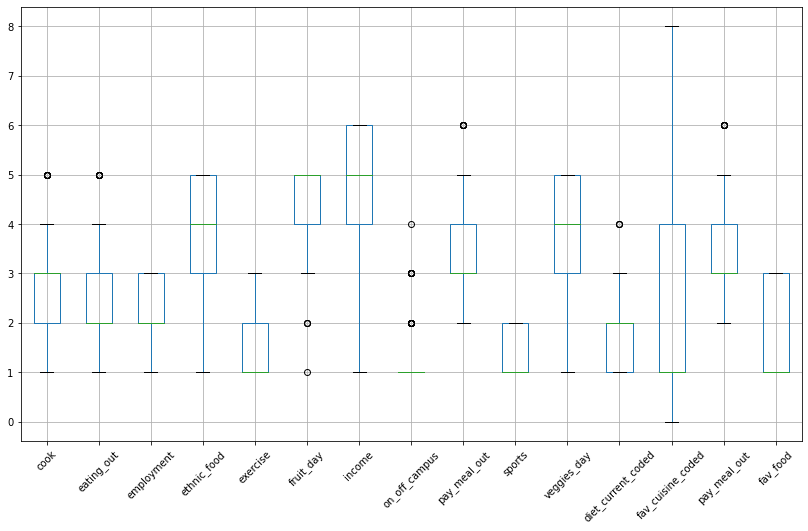

In [4]:
pd.plotting.boxplot(df_clean, figsize=[14, 8], rot=45)

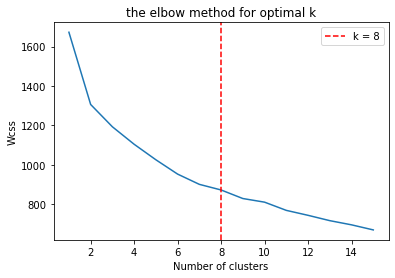

In [5]:
# doing elbow mehod to find the optimal k in kmeans

wcss = []

for i in range(1, 16):
    kmeans = KMeans(
        n_clusters=i, init="k-means++", max_iter=300, n_init=100, random_state=5
    )
    kmeans.fit(df_clean)
    wcss.append(kmeans.inertia_)

# best k : Lowest derivative
k = [i * 100 for i in np.diff(wcss, 2)].index(min([i * 100 for i in np.diff(wcss, 2)]))

# plotting the results oto a line graph, to find the opimal K or 'the elbow'

plt.plot(range(1, 16), wcss)
plt.title("the elbow method for optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Wcss")  # Witin cluster sum of squares
plt.axvline(k, ls="--", color="red", label="k = " + str(k))
plt.legend()
plt.show()

In [6]:
# location = [17.448372, 78.526957]
# Location of the place to search in
# location = [23.293334, 77.272205] # IISERB
# location=[17.98419,79.53111] # IIT-Bombay
location = [13.020929, 77.566241]  # IISC Banglore
url = f"https://api.foursquare.com/v3/places/search?ll={location[0]},{location[1]}&radius=100&limit=1"

headers = {
    "Accept": "application/json",
    "Authorization": "fsq3Mq7+IdcwsqfyuSSNlfLNX3cvUJvACsny0y7wJVEdPWM=",
}

response = requests.request("GET", url, headers=headers).json()

response
Place_name = response["results"][0]["name"]
Place_address = response["results"][0]["location"]["address"]
Place_name

'IISC Telcom Center BSNL Customer'

In [7]:
CLIENT_ID = "KTCJJ2YZ2143QHEZ2JAQS4FJIO5DLSDO0YN4YBXPMI5NKTEF"  # your Foursquare ID
CLIENT_SECRET = (
    "KNG2LO22BPLHN1E3OAHWLYQ5PQBN14XYZMEMAS0CPJEJKOTR"  # your Foursquare Secret
)
VERSION = "20200316"
LIMIT = 1000
RADIUS = 100000
QUERY = "apartment"

url = f"https://api.foursquare.com/v2/venues/search?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&query={QUERY}&query=apartment&v={VERSION}&ll={location[0]},{location[1]}&radius={RADIUS}&limit={LIMIT}"
results = requests.get(url).json()
d = pd.DataFrame(json_normalize(results["response"]["venues"]))
d.head()
# results

,id,name,categories,referralId,hasPerk,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.address,location.crossStreet,location.postalCode,location.neighborhood
0,56133261498e95c619c830f8,Dwellington Apartment,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",v-1638810526,False,13.039492,77.555590,"[{'label': 'display', 'lat': 13.03949179789228...",2367,IN,Bangalore,Karnātaka,India,"[Bangalore, Karnātaka, India]",NaN,NaN,NaN,NaN
1,4db7040e0437fa536a641766,Apartment Banaswadi main road cross hight stre...,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",v-1638810526,False,13.000170,77.624545,"[{'label': 'display', 'lat': 13.00017043034296...",6732,IN,Bangalore,Karnātaka,India,"[Banaswadi Main Rd (hight street), Bangalore, ...",Banaswadi Main Rd,hight street,NaN,NaN
2,5881e078ca10705c93250e49,Lavina Courts Apartment,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",v-1638810526,False,13.010092,77.577198,"[{'label': 'display', 'lat': 13.010092, 'lng':...",1693,IN,Bangalore,Karnātaka,India,"[7th cross Road, Bangalore, Karnātaka, India]",NaN,7th cross Road,NaN,NaN
3,54c7e234498e3fefe98bb233,Divya MSR Gateway Apartment,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",v-1638810526,False,13.039470,77.556732,"[{'label': 'display', 'lat': 13.03947021158443...",2307,IN,Bangalore,Karnātaka,India,"[MSR Road (Gokula Extension, Mathikere), Banga...",MSR Road,"Gokula Extension, Mathikere",560054,NaN
4,56925107498ee19055b48124,Surya Nest Apartment,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",v-1638810526,False,13.005177,77.563143,"[{'label': 'display', 'lat': 13.00517729269146...",1785,IN,Bangalore,Karnātaka,India,[#57 Surya Nest Apartment (15th Cross Malleshw...,#57 Surya Nest Apartment,15th Cross Malleshwarm,560003,NaN


In [8]:
d_clean = d.copy()[
    [
        "name",
        "location.formattedAddress",
        "location.distance",
        "location.lat",
        "location.lng",
        "id",
    ]
]
d_clean.to_csv("Data/apartment_clean.csv")

df_final = d_clean[["location.lat", "location.lng"]]

In [9]:
CafeList = []
DepList = []
GymList = []
# other = []
latit = list(d_clean["location.lat"])
longit = list(d_clean["location.lng"])

CLIENT_ID = "KTCJJ2YZ2143QHEZ2JAQS4FJIO5DLSDO0YN4YBXPMI5NKTEF"  # your Foursquare ID
CLIENT_SECRET = (
    "KNG2LO22BPLHN1E3OAHWLYQ5PQBN14XYZMEMAS0CPJEJKOTR"  # your Foursquare Secret
)
VERSION = "20200316"
LIMIT = 50

Nearby = {}
QUERIES = ["Cafe", "department-store", "Gym"]

for qry in QUERIES:
    Nearby[f"{qry}List"] = []
for lat, lng in zip(latit, longit):
    RADIUS = 5000
    for QUERI in QUERIES:

        url = f"https://api.foursquare.com/v2/venues/search?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&query={QUERI}&v={VERSION}&ll={lat},{lng}&radius={RADIUS}&limit={LIMIT}"
        result = requests.get(url).json()
        try:
            Nearby[f"{QUERI}List"].append(
                json_normalize(result["response"]["venues"])["name"].count()
            )
        except:
            continue
#         print(result)

In [10]:
df_final.loc[:, ["Cafes"]] = Nearby["CafeList"]
df_final.loc[:, ["department Stores"]] = Nearby["department-storeList"]
df_final.loc[:, ["Gyms"]] = Nearby["GymList"]

C:\Users\KHADGA JYOTH ALLI\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [11]:
df_final.head()

,location.lat,location.lng,Cafes,department Stores,Gyms
0,13.039492,77.555590,50,50,50
1,13.000170,77.624545,50,50,50
2,13.010092,77.577198,50,50,50
3,13.039470,77.556732,50,50,50
4,13.005177,77.563143,50,50,50


In [12]:
# k = 8
model = cluster.KMeans(n_clusters=k, init="k-means++")
X = df_final.loc[:, ["location.lat", "location.lng"]]
## clustering
dtf_X = X.loc[:, :]
dtf_X["Cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(
    model.cluster_centers_, dtf_X.drop("Cluster", axis=1).values
)
dtf_X.loc[:, "Centroids"] = 0
for i in closest:
    dtf_X.loc[i, "Centroids"] = 1
## add clustering info to the original dataset
df_final.loc[:, ["Cluster", "Centroids"]] = dtf_X.loc[:, ["Cluster", "Centroids"]]
df_final.loc[:, ["name"]] = d_clean.loc[:"name"]
df_final.head()

C:\Users\KHADGA JYOTH ALLI\anaconda3\lib\site-packages\pandas\core\indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


,location.lat,location.lng,Cafes,department Stores,Gyms,Cluster,Centroids,name
0,13.039492,77.555590,50,50,50,3,1,Dwellington Apartment
1,13.000170,77.624545,50,50,50,0,0,Apartment Banaswadi main road cross hight stre...
2,13.010092,77.577198,50,50,50,1,1,Lavina Courts Apartment
3,13.039470,77.556732,50,50,50,3,0,Divya MSR Gateway Apartment
4,13.005177,77.563143,50,50,50,1,0,Surya Nest Apartment


In [13]:
x, y = "location.lat", "location.lng"
color = "Cluster"
size = "Cafes"
popup = "name"
marker = "Centroids"
data = df_final.copy()
## create color column
lst_elements = sorted(list(df_final[color].unique()))
lst_colors = [
    "#%06X" % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))
]
data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3, 15))
data["size"] = scaler.fit_transform(data[size].values.reshape(-1, 1)).reshape(-1)
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron", zoom_start=11)
## add points
data.apply(
    lambda row: folium.CircleMarker(
        location=[row[x], row[y]],
        color=row["color"],
        fill=True,
        popup=row[popup],
        radius=row["size"],
    ).add_to(map_),
    axis=1,
)
## add html legend
legend_html = (
    """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""
    + color
    + """:</b><br>"""
)
for i in lst_elements:
    legend_html = (
        legend_html
        + """&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""
        + lst_colors[lst_elements.index(i)]
        + """">
     </i>&nbsp;"""
        + str(i)
        + """<br>"""
    )
legend_html = legend_html + """</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))
## add centroids marker
lst_elements = sorted(list(df_final[marker].unique()))
data[data[marker] == 1].apply(
    lambda row: folium.Marker(
        location=[row[x], row[y]],
        draggable=False,
        popup=row[popup],
        icon=folium.Icon(color="black"),
    ).add_to(map_),
    axis=1,
)
folium.Marker(
    location,
    popup=Place_address,
    tooltip=Place_name,
    icon=folium.Icon(color="red", icon="info-sign"),
).add_to(map_)

## saving the map
map_.save("map_Clustered.html")

## plot the map
map_